In [44]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import random

from skimage import io, transform

from torch.utils.data import Dataset, DataLoader


[[0.30989302454960477, 0.7299079362961791, 0.11326010206206849], [0.2275978997539837, 0.7602776849868479, 0.8042624776768628], [0.7889417172319263, 0.26601317692738013, 0.8323179735976726]]
(128, 128, 3)


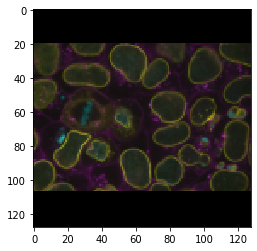

In [45]:
# functions to show an image

def imshow(img):
    plt.imshow(img)
    plt.show()

render_parameters = [random.random() for i in range(9)]
render_parameters = [[random.random() for i in range(3)] for j in range(3)]

print(render_parameters)
image = io.imread("\\\\allen\\aics\\animated-cell\\Allen-Cell-Explorer\\Allen-Cell-Explorer_1.4.0\\Cell-Viewer_Thumbnails\\AICS-13\\AICS-13_1516.png")
print(image.shape)
imshow(image)




<PIL.Image.Image image mode=RGB size=128x128 at 0x126BE92A908>


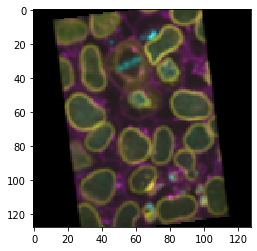

In [46]:
# rotate the image by a random angle, return result in rotated_image
apply_camera = transforms.RandomRotation(45, resample=PIL.Image.BICUBIC)
# print(image.shape)
# rotated_image = apply_camera(Image.fromarray(image))
# imshow(rotated_image)

random.seed(a=0)
convfilter = [[random.random() for i in range(3)] for j in range(3)]
convfilter = [[0,1,0], [1,1,1], [0,1,0]]
# 3 times for r,g,and b
render_parameters = [convfilter]
# print(image)
renderedimage = torch.nn.functional.conv2d(
    torch.Tensor([image.transpose(2,1,0)]), torch.Tensor([render_parameters, render_parameters, render_parameters]),
    bias=None, stride=1, 
    padding=1, dilation=1, 
    groups=3
)
# print(renderedimage)
# print(renderedimage.shape)
# print(renderedimage[0])

maxval = renderedimage.max()
renderedimage = torchvision.transforms.functional.normalize(renderedimage[0], mean=[0,0,0], std=[maxval, maxval, maxval])
renderedimage_pil = torchvision.transforms.functional.to_pil_image(renderedimage, mode=None)

final_image = apply_camera(renderedimage_pil)
print(final_image)
imshow(final_image)


In [111]:
class RenderStyleTransferDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.all_files = []
        for name in os.listdir(self.root_dir):
            full = os.path.join(self.root_dir, name)
            if os.path.isfile(full) and name[-4:]==".png":
                self.all_files.append(name)
        num_files = len(self.all_files)
        print(num_files)

    def __len__(self):
        return len(self.all_files)

    # returns a Tensor that is a 2D RGB image
    def render_function(self, input_data, render_params, camera_transform):
        # note that groups=3 and we only put one in the array here
        # this is reshaping to make the conv2d happy
        reshaped_params = [render_params]
        renderedimage = torch.nn.functional.conv2d(
            torch.Tensor([input_data]), torch.Tensor([reshaped_params, reshaped_params, reshaped_params]),
            bias=None, stride=1, 
            padding=1, dilation=1, 
            groups=3
        )
        maxval = renderedimage.max()

        renderedimage = torchvision.transforms.functional.normalize(renderedimage[0], mean=[0,0,0], std=[maxval, maxval, maxval])
        renderedimage_pil = torchvision.transforms.functional.to_pil_image(renderedimage, mode=None)

        final_image = camera_transform(renderedimage_pil)
        final_image = torchvision.transforms.functional.to_tensor(final_image)
        return final_image
        
    
    def __getitem__(self, idx):
        # load some input_data for our render_function
        img_name = os.path.join(self.root_dir, self.all_files[idx])
        image = io.imread(img_name)
        
        # generate a repeatable set of render parameters for our render_function
        random.seed(a=idx)
        convfilter = [[random.random() for i in range(3)] for j in range(3)]

        camera_samples = 10
        camera_degree_range = 45.0
        apply_camera = transforms.RandomRotation(camera_degree_range, resample=PIL.Image.BICUBIC)

        # loop
        images = []
        for i in range(camera_samples):
            renderedimage = self.render_function(image.transpose(2,1,0), convfilter, apply_camera)
            images.append(renderedimage)
        im_2d_cube_ids = [idx for i in range(camera_samples)]
        render_params = [convfilter for i in range(camera_samples)]

        im_as_tensor = torchvision.transforms.functional.to_tensor(image)
        # sample = {'im_cube': image, 'im_2d': images, 'im_2d_cube_id': im_2d_cube_ids, 'render_parameters': convfilter}
        sample = (im_as_tensor, images, im_2d_cube_ids, render_params)

        return sample



8


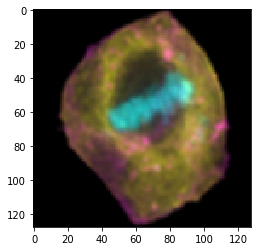

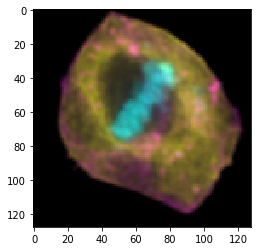

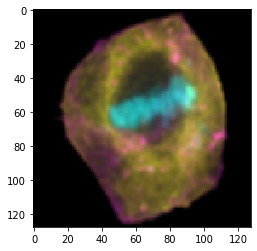

In [48]:
testDataset = RenderStyleTransferDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\test\\fake_dataset")
# testDataset = TestConvDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\test\\fake_dataset")
item = testDataset.__getitem__(0)
# print(item)
imshow(torchvision.transforms.functional.to_pil_image(item[1][0], mode=None))
imshow(torchvision.transforms.functional.to_pil_image(item[1][1], mode=None))
imshow(torchvision.transforms.functional.to_pil_image(item[1][2], mode=None))


In [49]:
#Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

# train (bool, optional) 
# split the data set based on the value of train into a repeatable 80%-20% split
trainset = RenderStyleTransferDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\renderstyletransfer\\training_data", train=True)
testset = RenderStyleTransferDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\renderstyletransfer\\training_data", train=False)

# takes the trainset we defined, loads 4 (default 1) at a time, 
# shuffle=True reshuffles the data every epoch
# for shuffle, an epoch is defined as one full iteration through the DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

# same as trainloader 
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)


600
600


In [50]:
# verify what we expect the data loader to do
dataiter = iter(trainloader)
im_cube, im_2d, im_2d_cube_id, psi = dataiter.next()
print(len(im_2d_cube_id))
print(im_2d_cube_id)
print(len(psi))
print(psi)
# for i, data in enumerate(trainloader, 0):
#     # get the inputs; data is a list of [inputs, labels]
#     im_cube, im_2d, im_2d_cube_id, psi = data


10
[tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133]), tensor([589,   1, 176, 133])]
3
[[tensor([0.1207, 0.1344, 0.0297, 0.4938], dtype=torch.float64), tensor([0.6439, 0.8474, 0.7674, 0.4824], dtype=torch.float64), tensor([0.2892, 0.7638, 0.2236, 0.7690], dtype=torch.float64)], [tensor([0.7298, 0.2551, 0.1111, 0.8083], dtype=torch.float64), tensor([0.9402, 0.4954, 0.8951, 0.3387], dtype=torch.float64), tensor([0.2299, 0.4495, 0.6360, 0.5450], dtype=torch.float64)], [tensor([0.4938, 0.6516, 0.6273, 0.6209], dtype=torch.float64), tensor([0.0948, 0.7887, 0.5711, 0.7094], dtype=torch.float64), tensor([0.8373, 0.0939, 0.0995, 0.9502], dtype=torch.float64)]]


In [81]:
# torch.nn.Module is the base class for all neural network modules
# Your models should also subclass this class.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #  nn.Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
        # args: in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        # This results in 2 "parameters": 6 learned kernels of size 5x5 per input channel (3) plus 6 learned scalar bias terms
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Applies a 2D max pooling over an input signal composed of several input planes.
        # args: (kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        # This results in 2x2 downsampling with a "max" filter
        self.pool = nn.MaxPool2d(2, 2)
        # This results in 2 "parameters": 16 learned kernels of size 5x5 per input channel (6) plus 16 learned scalar bias terms
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Applies a linear transformation to the incoming data: y = xA^T + b
        # args: (in_features, out_features, bias=True)
        # This results in 2 "parameters": 120 learned linear weight vectors of length 16*5*5, plus 120 learned scalar bias terms
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # This results in 2 "parameters": 84 learned linear weight vectors of length 120, plus 84 learned scalar bias terms
        self.fc2 = nn.Linear(120, 84)
        # This results in 2 "parameters": 10 learned linear weight vectors of length 84, plus 10 learned scalar bias terms
        self.fc3 = nn.Linear(84, 10)

    # running data through the network
    def forward(self, x):
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv1(x)))
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv2(x)))
        # reshape tensor x to have its second dimension be of size 16*5*5,
        # (to fit into the fc1 ?) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [109]:
# compute a style representation from a collection of images
class FStyle(nn.Module):
    def __init__(self):
        super(FStyle, self).__init__()
        #  nn.Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
        # args: in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        # This results in 2 "parameters": 6 learned kernels of size 5x5 per input channel (3) plus 6 learned scalar bias terms
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Applies a 2D max pooling over an input signal composed of several input planes.
        # args: (kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        # This results in 2x2 downsampling with a "max" filter
        self.pool = nn.MaxPool2d(2, 2)
        self.pool5 = nn.MaxPool2d(5, 5)
        # This results in 2 "parameters": 16 learned kernels of size 5x5 per input channel (6) plus 16 learned scalar bias terms
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Applies a linear transformation to the incoming data: y = xA^T + b
        # args: (in_features, out_features, bias=True)
        # This results in 2 "parameters": 120 learned linear weight vectors of length 16*5*5, plus 120 learned scalar bias terms
        self.fc1 = nn.Linear(16 * 19 * 19, 120)
        # This results in 2 "parameters": 84 learned linear weight vectors of length 120, plus 84 learned scalar bias terms
        self.fc2 = nn.Linear(120, 84)
        # This results in 2 "parameters": 10 learned linear weight vectors of length 84, plus 10 learned scalar bias terms
        self.fc3 = nn.Linear(84, 10)

    # running data through the network
    def forward(self, x):
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv1(x)))
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool5(x)
        # reshape tensor x to have its second dimension be of size 16*5*5,
        # (to fit into the fc1 ?) 
        x = x.view(-1, 16 * 19 * 19)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [113]:
# compute a set of render parameters (psi) given an input_data and style
class FPsi(nn.Module):
    def __init__(self, num_render_params=9):
        super(FPsi, self).__init__()
        #  nn.Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
        # args: in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        # This results in 2 "parameters": 6 learned kernels of size 5x5 per input channel (3) plus 6 learned scalar bias terms
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Applies a 2D max pooling over an input signal composed of several input planes.
        # args: (kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        # This results in 2x2 downsampling with a "max" filter
        self.pool = nn.MaxPool2d(2, 2)
        self.pool19 = nn.MaxPool2d(19, 19)        
        # This results in 2 "parameters": 16 learned kernels of size 5x5 per input channel (6) plus 16 learned scalar bias terms
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Applies a linear transformation to the incoming data: y = xA^T + b
        # args: (in_features, out_features, bias=True)
        # This results in 2 "parameters": 120 learned linear weight vectors of length 16*5*5, plus 120 learned scalar bias terms
        self.fc1 = nn.Linear(16 * 19 * 19, 120)
        # This results in 2 "parameters": 84 learned linear weight vectors of length 120, plus 84 learned scalar bias terms
        self.fc2 = nn.Linear(120, 84)
        # This results in 2 "parameters": 10 learned linear weight vectors of length 84, plus 10 learned scalar bias terms
        self.fc3 = nn.Linear(84, num_render_params)

    # running data through the network
    def forward(self, x, y):
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv1(x)))
        # relu seems to basically clip the min at 0
        x = self.pool19(F.relu(self.conv2(x)))
        # reshape tensor x to have its second dimension be of size 16*5*5,
        # (to fit into the fc1 ?) 
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [107]:
# does this make sense?
class FullNetwork(nn.Module):
    def __init__(self):
        super(FullNetwork, self).__init__()
        self.f_style = FStyle()
        self.f_psi = FPsi()
 
    # running data through the network
    def forward(self, x):
        x = self.f_style(x)
        x = self.f_psi(x)
        return x


In [112]:
# test f_style
full_network = FullNetwork()
f_style = full_network.f_style
x = torch.zeros((40, 3, 392, 392))
print(x.shape)
x = f_style.pool(F.relu(f_style.conv1(x)))
print(x.shape)
x = f_style.pool(F.relu(f_style.conv2(x)))
print(x.shape)
x = f_style.pool5(x)
print(x.shape)

x = x.view(-1, 16 * 19 * 19)
print(x.shape)
x = F.relu(f_style.fc1(x))
print(x.shape)
x = F.relu(f_style.fc2(x))
print(x.shape)
x = f_style.fc3(x)
print(x.shape)


torch.Size([40, 3, 392, 392])
torch.Size([40, 6, 194, 194])
torch.Size([40, 16, 95, 95])
torch.Size([40, 16, 19, 19])
torch.Size([40, 5776])
torch.Size([40, 120])
torch.Size([40, 84])
torch.Size([40, 10])


In [118]:
# test f_psi
full_network = FullNetwork()
f_psi = full_network.f_psi
# batch of input_datas
x = torch.zeros((40, 3, 392, 392))
# batch of styles
#x = torch.zeros((40, 10))
print(x.shape)
# return a 3x3 render_parameters (40x9)


x = f_psi.pool(F.relu(f_psi.conv1(x)))
print(x.shape)
x = f_psi.pool19(F.relu(f_psi.conv2(x)))
print(x.shape)
x = x.view(40, -1)
print(x.shape)
x = F.relu(f_psi.fc1(x))
x = F.relu(f_psi.fc2(x))
x = f_psi.fc3(x)


torch.Size([40, 3, 392, 392])
torch.Size([40, 6, 194, 194])
torch.Size([40, 16, 10, 10])
torch.Size([40, 1600])


RuntimeError: size mismatch, m1: [40 x 1600], m2: [5776 x 120] at ..\aten\src\TH/generic/THTensorMath.cpp:961

In [70]:
full_network = FullNetwork()
loss_fn = nn.MSELoss()
regularization_rate = 0.1 # aka lambda
# Implements stochastic gradient descent (optionally with momentum).
# lr is the learning rate, required
optimizer = optim.SGD(full_network.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    # trainloader is the method that gets 4 examples out of the training dataset at a time
    # each epoch trainloader will shuffle the data because we told it to
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        im_cube, im_2d, im_2d_cube_id, psi = data
        
        batch_of_ids = torch.cat(im_2d_cube_id)
        batch_of_psis = torch.cat(psi)
#         style = f_style(torch.concat(im_2d))
#         # psi_hat should be same format as psi (a batch of render_params)
#         psi_hat = f_psi(im_cube, style)
        
        # (psi_hat, style) = full_network(torch.concat(torch.concat(im_2d), im_cube))

        # because f_style and f_psi are interdependent and we want to do one single backprop
        # using optim.SGD
        batch_of_styles = full_network.f_style(torch.cat(im_2d))
        # psi_hat should be same format as psi (a batch of render_params)
        psi_hat = full_network.f_psi(im_cube, batch_of_styles)

        loss_psi = loss_fn(psi_hat, batch_of_psis)
        loss_style = torch.zeros(1)
        
        for i, s in enumerate(batch_of_styles):
            # get all ids that are the same as i
            list_of_same_ids = torch.find(batch_of_ids, im_2d_cube_id[i] == im_2d_cube_id)
            # pick one
            id_same = randomly_choose(list_of_same_ids)
            # get all ids that are different than i
            list_of_different_ids = torch.find(batch_of_ids, im_2d_cube_id[i] != im_2d_cube_id)
            # pick one
            id_different = randomly_choose(list_of_different_ids)
            # compute loss
            loss_style = loss_style + (s - batch_of_styles[id_same])**2 - (s - batch_of_styles[id_different])**2

        loss_style = loss_style/len(batch_of_styles)
        total_loss = loss_psi + regularization_rate*loss_style

        total_loss.backward()

        logger.log(loss_psi, loss_style)

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        everyN = 10
        if i % everyN == everyN-1:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / everyN))
            running_loss = 0.0

print('Finished Training')


AttributeError: 'list' object has no attribute 'size'

In [ ]:
dataiter = iter(testloader)
# grab batch of four images again but from data it hasn't seen before
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# calc outputs with our trained network
# outputs are batch size (4) by 10 (number of classes)
# each number is the confidence that the current image is in that class 
# higher number means more confident
outputs = net(images)
# print(outputs)
# outputs are tensors, but we want the one it thinks is most likely 
# torch.max returns (max_value, index)
# therefore "predicted" will hold the index of the max value so we can get the name of the class from the classes array
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# calc percentage calc labels match the real labels in the testing set
with torch.no_grad():  # just in prediction mode, not learning mode
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)
